In [ ]:
# Install Kaggle API
!pip install -q kaggle

In [ ]:
# Upload kaggle.json to Colab
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"arrnavgg","key":"ff25388edb1788e1e80a933870018c3d"}'}

In [ ]:
# Make a directory for Kaggle and move the kaggle.json file there
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Download the dataset using Kaggle API
!kaggle datasets download -d concaption/pepsico-lab-potato-quality-control

Dataset URL: https://www.kaggle.com/datasets/concaption/pepsico-lab-potato-quality-control
License(s): CC0-1.0
100% 940M/940M [00:49<00:00, 26.6MB/s]
100% 940M/940M [00:49<00:00, 20.1MB/s]


In [ ]:
# Unzip the downloaded dataset
!unzip pepsico-lab-potato-quality-control.zip -d /content/pepsico_dataset


Archive:  pepsico-lab-potato-quality-control.zip
  inflating: /content/pepsico_dataset/Pepsico RnD Potato Lab Dataset/Test/Defective/IMG_20210319_004702.jpg  
  inflating: /content/pepsico_dataset/Pepsico RnD Potato Lab Dataset/Test/Defective/IMG_20210319_004710.jpg  
  inflating: /content/pepsico_dataset/Pepsico RnD Potato Lab Dataset/Test/Defective/IMG_20210319_004801.jpg  
  inflating: /content/pepsico_dataset/Pepsico RnD Potato Lab Dataset/Test/Defective/IMG_20210319_004806.jpg  
  inflating: /content/pepsico_dataset/Pepsico RnD Potato Lab Dataset/Test/Defective/IMG_20210319_004811.jpg  
  inflating: /content/pepsico_dataset/Pepsico RnD Potato Lab Dataset/Test/Defective/IMG_20210319_004816.jpg  
  inflating: /content/pepsico_dataset/Pepsico RnD Potato Lab Dataset/Test/Defective/IMG_20210319_004816_1.jpg  
  inflating: /content/pepsico_dataset/Pepsico RnD Potato Lab Dataset/Test/Defective/IMG_20210319_004823.jpg  
  inflating: /content/pepsico_dataset/Pepsico RnD Potato Lab Dataset/

2 directories and 0 images in '/content/pepsico_dataset/Pepsico RnD Potato Lab Dataset'
2 directories and 1 images in '/content/pepsico_dataset/Pepsico RnD Potato Lab Dataset/Test'
0 directories and 93 images in '/content/pepsico_dataset/Pepsico RnD Potato Lab Dataset/Test/Defective'
0 directories and 101 images in '/content/pepsico_dataset/Pepsico RnD Potato Lab Dataset/Test/Not Defective'
2 directories and 1 images in '/content/pepsico_dataset/Pepsico RnD Potato Lab Dataset/Train'
0 directories and 370 images in '/content/pepsico_dataset/Pepsico RnD Potato Lab Dataset/Train/Defective'
0 directories and 401 images in '/content/pepsico_dataset/Pepsico RnD Potato Lab Dataset/Train/Non-Defective'
Found 616 images belonging to 2 classes.
Found 153 images belonging to 2 classes.
Found 192 images belonging to 2 classes.


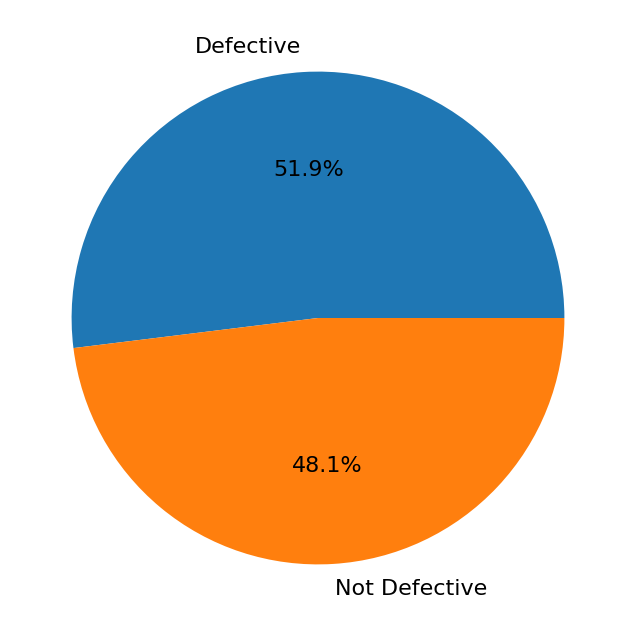

9406464/9406464 [==============================] - 1s 0us/step
Epoch 1/30
19/19 [==============================] - ETA: 0s - loss: 0.5885 - accuracy: 0.6798
Epoch 1: val_loss improved from inf to 0.40758, saving model to model.keras
19/19 [==============================] - 89s 4s/step - loss: 0.5885 - accuracy: 0.6798 - val_loss: 0.4076 - val_accuracy: 0.9219 - lr: 1.0000e-04
Epoch 2/30
19/19 [==============================] - ETA: 0s - loss: 0.3581 - accuracy: 0.8750
Epoch 2: val_loss improved from 0.40758 to 0.26426, saving model to model.keras
19/19 [==============================] - 80s 4s/step - loss: 0.3581 - accuracy: 0.8750 - val_loss: 0.2643 - val_accuracy: 0.9453 - lr: 1.0000e-04
Epoch 3/30
19/19 [==============================] - ETA: 0s - loss: 0.2790 - accuracy: 0.9212
Epoch 3: val_loss improved from 0.26426 to 0.20863, saving model to model.keras
19/19 [==============================] - 80s 4s/step - loss: 0.2790 - accuracy: 0.9212 - val_loss: 0.2086 - val_accuracy: 0.968

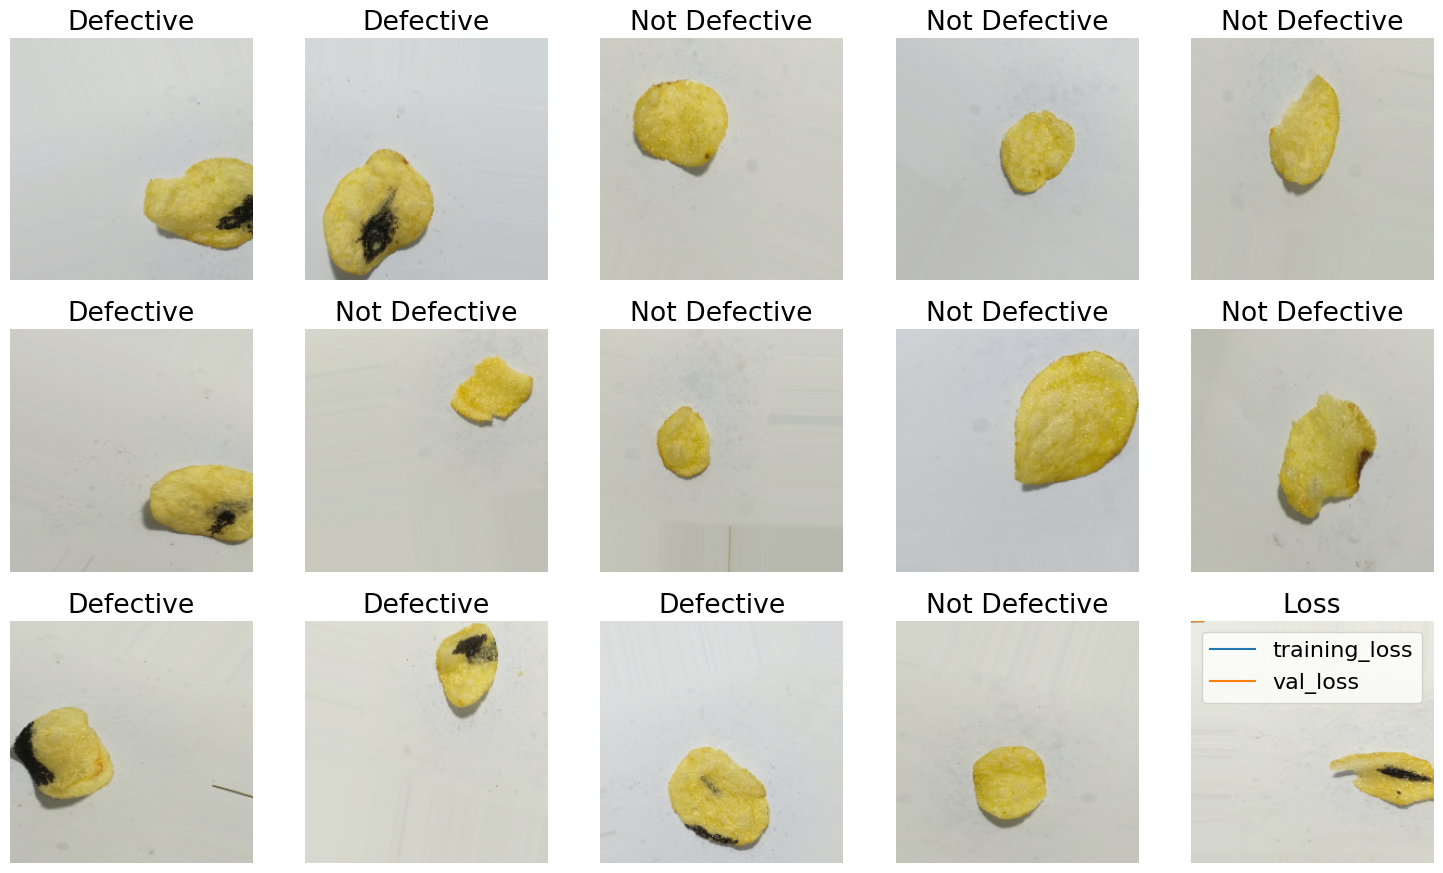

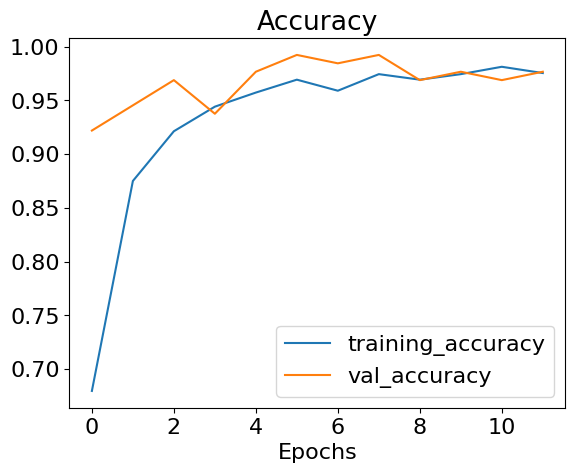

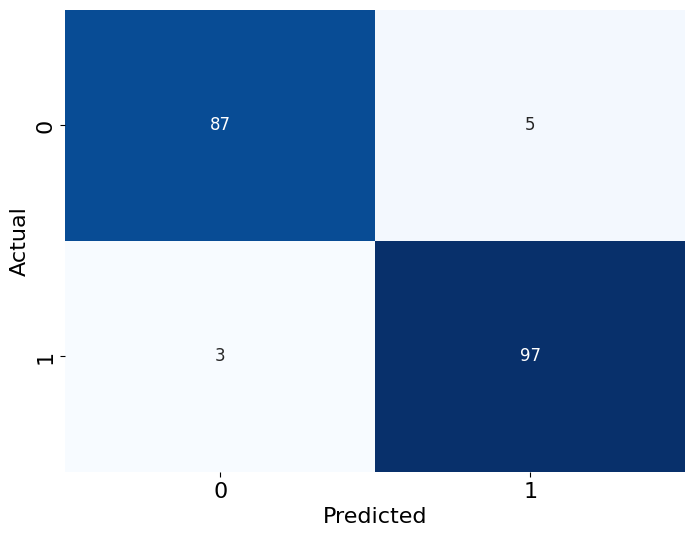

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report, confusion_matrix

# Suppress TensorFlow logging warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.get_logger().setLevel('ERROR')

# Set random seed for reproducibility
tf.random.set_seed(40)

# Model file name
model_name = "model.keras"

# Define callbacks
checkpoint = ModelCheckpoint(model_name,
                             monitor="val_loss",
                             mode="min",
                             save_best_only=True,
                             verbose=1)
earlystopping = EarlyStopping(monitor='val_loss',
                              min_delta=0.001,
                              patience=5,
                              verbose=1,
                              restore_best_weights=True)
reducelr = ReduceLROnPlateau(monitor='val_loss',
                             factor=0.2,
                             patience=2,
                             verbose=1,
                             min_lr=1e-7)

# Directories for data
MAIN_DIR = "/content/pepsico_dataset/Pepsico RnD Potato Lab Dataset"  # Update this path accordingly
train_dir = os.path.join(MAIN_DIR, "Train")
test_dir = os.path.join(MAIN_DIR, "Test")

# Print dataset details
for dirpath, dirnames, filenames in os.walk(MAIN_DIR):
    print(f"{len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")

# Image size and batch size
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

# Data generators with more augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(directory=train_dir,
                                               batch_size=BATCH_SIZE,
                                               target_size=IMAGE_SIZE,
                                               class_mode="binary",
                                               subset="training",
                                               shuffle=True,
                                               seed=40)

valid_data = train_datagen.flow_from_directory(directory=train_dir,
                                               batch_size=BATCH_SIZE,
                                               target_size=IMAGE_SIZE,
                                               class_mode="binary",
                                               subset="validation",
                                               shuffle=True,
                                               seed=40)

test_data = test_datagen.flow_from_directory(directory=test_dir,
                                             batch_size=BATCH_SIZE,
                                             target_size=IMAGE_SIZE,
                                             class_mode="binary",
                                             shuffle=False,
                                             seed=40)

# Plot class distribution
plt.rcParams['font.size'] = 16
plt.figure(figsize=(12, 8))
labels = train_data.labels
vc = pd.Series(labels).value_counts()
plt.pie(vc, labels=['Defective', 'Not Defective'], autopct='%1.1f%%')
plt.show()

# Plot sample images
plt.figure(figsize=(15, 9))

batch = next(train_data)
for i in range(15):
    axs = plt.subplot(3, 5, i + 1)
    plt.imshow(batch[0][i])
    plt.axis('off')
    axs.set_title("Defective" if batch[1][i] == 0 else "Not Defective")
    axs.set_xticklabels([])
    axs.set_yticklabels([])
    plt.subplots_adjust(wspace=None, hspace=None)
plt.tight_layout()

# Build the model with transfer learning
base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False

model_1 = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model with a lower learning rate
model_1.compile(loss=BinaryCrossentropy(),
                optimizer=Adam(learning_rate=1e-4),
                metrics=['accuracy'])

# Train the model
train_steps_per_epoch = train_data.samples // train_data.batch_size
validation_steps = valid_data.samples // valid_data.batch_size

history_1 = model_1.fit(train_data,
                        epochs=30,
                        steps_per_epoch=train_steps_per_epoch,
                        validation_data=valid_data,
                        validation_steps=validation_steps,
                        callbacks=[checkpoint, earlystopping, reducelr])

# Function to plot training curves
def plot_curves(history):
    """
    Returns separate loss and accuracy curves
    """
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    epochs = range(len(history.history["loss"]))

    plt.plot(epochs, loss, label="training_loss")
    plt.plot(epochs, val_loss, label="val_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()
    plt.figure()

    plt.plot(epochs, accuracy, label="training_accuracy")
    plt.plot(epochs, val_accuracy, label="val_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

plot_curves(history_1)

# Evaluate the model
result = model_1.evaluate(test_data, verbose=0)
print(f"Accuracy on Evaluation: {result[1]*100:.2f}%\nLoss: {result[0]:.4f}")

# Predict and plot confusion matrix
y_true = test_data.classes
y_pred = model_1.predict(test_data, verbose=0)
y_pred = (y_pred > 0.5).astype(int).flatten()

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_true, y_pred), cbar=False, annot=True, annot_kws={"fontsize":12}, fmt='.3g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


> Accuracy on Evaluation: 95.83% <br>
> Loss: 0.1120


In [ ]:
!pip install streamlit ngrok tensorflow

In [ ]:
%%writefile app.py
import streamlit as st
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

# Load the model
model = tf.keras.models.load_model('model.keras')

# Define the class names
class_names = ['Defective', 'Not Defective']

# Define a function to predict the class of the image
def predict(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create a batch
    predictions = model.predict(img_array)
    score = predictions[0]
    return score

# Set up the Streamlit interface
st.title("Defective Potato Chip Detection")

# Add a file uploader to allow users to upload images
uploaded_file = st.file_uploader("Choose an image...", type="jpg")

if uploaded_file is not None:
    image = Image.open(uploaded_file)
    st.image(image, caption='Uploaded Image.', use_column_width=True)
    st.write("")
    st.write("Classifying...")

    # Save the uploaded file to a temporary location
    temp_file_path = "temp.jpg"
    with open(temp_file_path, "wb") as f:
        f.write(uploaded_file.getbuffer())

    # Predict the class of the image
    score = predict(temp_file_path)
    class_index = int(score > 0.5)
    class_label = class_names[class_index]
    confidence = score if class_index == 1 else 1 - score

    st.write(f"Prediction: {class_label}")
    st.write(f"Confidence: {confidence[0]*100:.2f}%")

    # Clean up the temporary file
    os.remove(temp_file_path)


Overwriting app.py


In [ ]:
model_1.save("model.keras")


In [ ]:
!pip install pyngrok
from pyngrok import ngrok

# Replace 'your_auth_token' with your actual Ngrok auth token
ngrok.set_auth_token('2iyq9hyhCVq20DcK6j6DDA2nRVj_23EnAhKpD8nz6bL8BsTC6')

# Terminate any open tunnels
ngrok.kill()

# Create a new tunnel
public_url = ngrok.connect(8501)
print(f"Streamlit app will be available on: {public_url}")

!streamlit run app.py

Streamlit app will be available on: NgrokTunnel: "https://cc2d-34-80-224-26.ngrok-free.app" -> "http://localhost:8501"



  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.80.224.26:8501

